# OpenEO Connection to Google Earth Engine

In [1]:
import openeo
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
# Define constants
# TODO: Deprecated: release-0.0.2, Update to 0.3.1 version
# Connection
GEE_DRIVER_URL = "http://giv-project8.uni-muenster.de/"
OUTPUT_FILE = "/tmp/openeo_gee_output.png"
OUTFORMAT = "png"

# Data
PRODUCT_ID = "COPERNICUS/S2"

DATE_START = "2017-01-01"
DATE_END = "2017-01-31"

IMAGE_LEFT = 9.0
IMAGE_RIGHT = 9.1
IMAGE_TOP = 12.1
IMAGE_BOTTOM = 12.0
IMAGE_SRS = "EPSG:4326"

# Processes
NDVI_RED = "B4"
NDVI_NIR = "B8"

STRECH_COLORS_MIN = -1
STRECH_COLORS_MAX = 1

In [3]:
# Connect with GEE backend
session = openeo.session("nobody", GEE_DRIVER_URL)
session

In [4]:
# Get available processes from the back end.
processes = session.get_all_processes()
processes

[{'process_id': 'zonal_statistics',
  'description': 'Calculates statistics for each zone specified in a file.'},
 {'process_id': 'NDVI',
  'description': 'Finds the minimum value of time series for all bands of the input dataset.'},
 {'process_id': 'filter_bands',
  'description': 'Selects certain bands from a collection.'},
 {'process_id': 'filter_bbox',
  'description': 'Drops observations from a collection that are located outside of a given bounding box.'},
 {'process_id': 'filter_daterange',
  'description': 'Drops observations from a collection that have been captured before a start or after a given end date.'},
 {'process_id': 'count_time',
  'description': 'Counts the number of images with a valid mask in a time series for all bands of the input dataset.'},
 {'process_id': 'max_time',
  'description': 'Finds the maximum value of a time series for all bands of the input dataset.'},
 {'process_id': 'min_time',
  'description': 'Finds the minimum value of a time series for all ba

In [5]:
# Get detailed information about process from the back end.
process = session.get_process('NDVI')
process

{'process_id': 'NDVI',
 'description': 'Finds the minimum value of time series for all bands of the input dataset.',
 'args': {'imagery': {'description': 'image or image collection'},
  'red': {'description': 'reference to the red band'},
  'nir': {'description': 'reference to the nir band'}}}

In [5]:
# Retrieve the list of available collections
collections = session.list_collections()

list(collections)[:5]
session.get_collection(PRODUCT_ID)

{'product_id': 'COPERNICUS/S2',
 'description': 'Sentinel-2 MSI: MultiSpectral Instrument, Level-1C',
 'source': 'European Union/ESA/Copernicus, https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi',
 'time': {'from': '2015-06-23', 'to': '2018-06-27'},
 'bands': [{'band_id': 'B1'},
  {'band_id': 'B2'},
  {'band_id': 'B3'},
  {'band_id': 'B4'},
  {'band_id': 'B5'},
  {'band_id': 'B6'},
  {'band_id': 'B7'},
  {'band_id': 'B8'},
  {'band_id': 'B8A'},
  {'band_id': 'B9'},
  {'band_id': 'B10'},
  {'band_id': 'B11'},
  {'band_id': 'B12'},
  {'band_id': 'QA10'},
  {'band_id': 'QA20'},
  {'band_id': 'QA60'}],
 'extent': {'srs': 'EPSG:4326',
  'left': -180,
  'right': 180,
  'bottom': -90,
  'top': 90}}

In [18]:
# Select collection product
coperincus_s2_image = session.image(PRODUCT_ID)

session.get_all_processes()

[{'process_id': 'zonal_statistics',
  'description': 'Calculates statistics for each zone specified in a file.'},
 {'process_id': 'NDVI',
  'description': 'Finds the minimum value of time series for all bands of the input dataset.'},
 {'process_id': 'filter_bands',
  'description': 'Selects certain bands from a collection.'},
 {'process_id': 'filter_bbox',
  'description': 'Drops observations from a collection that are located outside of a given bounding box.'},
 {'process_id': 'filter_daterange',
  'description': 'Drops observations from a collection that have been captured before a start or after a given end date.'},
 {'process_id': 'count_time',
  'description': 'Counts the number of images with a valid mask in a time series for all bands of the input dataset.'},
 {'process_id': 'max_time',
  'description': 'Finds the maximum value of a time series for all bands of the input dataset.'},
 {'process_id': 'min_time',
  'description': 'Finds the minimum value of a time series for all ba

In [9]:
# Specifying the date range and the bounding box
timeseries = openeo.bbox_filter(coperincus_s2_image, left=IMAGE_LEFT, right=IMAGE_RIGHT, top=IMAGE_TOP,
                                             bottom=IMAGE_BOTTOM, srs=IMAGE_SRS)
timeseries = openeo.date_range_filter(timeseries, DATE_START, DATE_END)

timeseries

In [14]:
# Applying some operations on the data
timeseries = openeo.ndvi(timeseries, NDVI_RED, NDVI_NIR)
timeseries = openeo.min_time(timeseries)
timeseries = openeo.stretch_colors(timeseries, STRECH_COLORS_MIN, STRECH_COLORS_MAX)

timeseries.graph

{'process_id': 'stretch_colors',
 'args': {'imagery': {'process_id': 'min_time',
   'args': {'imagery': {'process_id': 'NDVI',
     'args': {'imagery': {'process_id': 'stretch_colors',
       'args': {'imagery': {'process_id': 'min_time',
         'args': {'imagery': {'process_id': 'NDVI',
           'args': {'imagery': {'process_id': 'filter_daterange',
             'args': {'imagery': {'process_id': 'filter_bbox',
               'args': {'imagery': {'product_id': 'COPERNICUS/S2'},
                'left': 9.0,
                'right': 9.1,
                'top': 12.1,
                'bottom': 12.0,
                'srs': 'EPSG:4326'}},
              'from': '2017-01-01',
              'to': '2017-01-31'}},
            'red': 'B4',
            'nir': 'B8'}}}},
        'min': -1,
        'max': 1}},
      'red': 'B4',
      'nir': 'B8'}}}},
  'min': -1,
  'max': 1}}

In [11]:
# Sending the job to the backend
job = timeseries.send_job(out_format=OUTFORMAT)

job

In [12]:
# Download job result
job.download(OUTPUT_FILE)

job

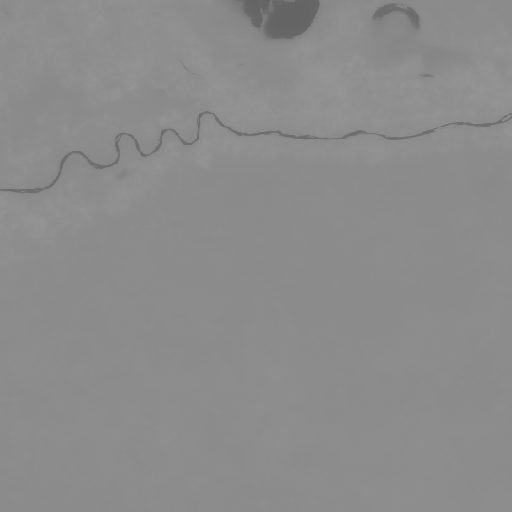

In [13]:
# Showing the result
from IPython.display import Image
result = Image(filename=OUTPUT_FILE)

result